In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# Read the concatenated CSV file into a dataframe
fake_real_csv_path = "/content/drive/MyDrive/fake_vs_real/fake_vs_real/fake_real_dataset.csv"
fake_real_df = pd.read_csv(fake_real_csv_path)

# Define the percentage for train, test, and validation splits
test_size = 0.2  # 20% for testing
validation_size = 0.1  # 10% for validation

# Perform the train-test split
train_df, test_df = train_test_split(fake_real_df, test_size=test_size, random_state=42)

# Perform the train-validation split
train_df, valid_df = train_test_split(train_df, test_size=validation_size, random_state=42)

# Print the lengths of the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 2187
Validation set size: 243
Test set size: 608


In [4]:
from PIL import Image
import csv
import os

def is_valid_image(path):
    try:
        # Open the image file
        with Image.open(path) as img:
            # Check if the image can be loaded
            return True
    except (IOError, SyntaxError):
        # If there's an error loading the image, consider it invalid
        return False

def check_image_paths(csv_file_path):
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if row:
                image_path = row[0]
                # Check if the image path is not valid
                if not os.path.exists(image_path) or not is_valid_image(image_path):
                    print(f"{image_path} is not a valid image.")

# Replace 'your_file.csv' with the path to your CSV file
csv_file_path = '/content/drive/MyDrive/fake_vs_real/fake_vs_real/fake_real_dataset.csv'
check_image_paths(csv_file_path)


path is not a valid image.


In [5]:
# Count the number of real and fake images in each set
def count_labels(df):
    real_count = df[df['label'] == 'real'].shape[0]
    fake_count = df[df['label'] == 'fake'].shape[0]
    return real_count, fake_count

# Count for train set
train_real_count, train_fake_count = count_labels(train_df)
print(f"Train set - Real: {train_real_count}, Fake: {train_fake_count}")

# Count for validation set
validation_real_count, validation_fake_count = count_labels(valid_df)
print(f"Validation set - Real: {validation_real_count}, Fake: {validation_fake_count}")

# Count for test set
test_real_count, test_fake_count = count_labels(test_df)
print(f"Test set - Real: {test_real_count}, Fake: {test_fake_count}")

Train set - Real: 1228, Fake: 959
Validation set - Real: 127, Fake: 116
Test set - Real: 345, Fake: 263


In [6]:
# Define a mapping for labels
label_mapping = {'real': 0, 'fake': 1}

# Replace the 'label' column with the binary labels
train_df['label'] = train_df['label'].map(label_mapping)
valid_df['label'] = valid_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

# Print the first few rows to verify the changes
print("Train set:")
print(train_df.head())

print("\nValidation set:")
print(valid_df.head())

print("\nTest set:")
print(test_df.head())


Train set:
                                                   path  label
419   /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
1840  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
220   /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
95    /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
1622  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      1

Validation set:
                                                   path  label
2637  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      1
1141  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
607   /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
1508  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      1
2160  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      1

Test set:
                                                   path  label
1721  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
2334  /content/drive/MyDrive/fake_vs_real/fake_vs_re...      0
443   /content/d

In [7]:
image_df = []
for image in train_df['path']:
    img = cv2.imread(image)
    resized = cv2.resize(img,(224,224))
    image_df.append(resized)
image_array = np.array(image_df)
X_train = image_array/255
y_train = train_df['label']

In [8]:
image_df = []
for image in valid_df['path']:
    img = cv2.imread(image)
    resized = cv2.resize(img,(224,224))
    image_df.append(resized)
image_array = np.array(image_df)
X_valid = image_array/255
y_valid = valid_df['label']

In [9]:
image_df = []
for image in test_df['path']:
    img = cv2.imread(image)
    resized = cv2.resize(img,(224,224))
    image_df.append(resized)
image_array = np.array(image_df)
X_test = image_array/255
y_test = test_df['label']

In [10]:
from tensorflow.keras import models, layers

input_shape = (224, 224, 3)

model = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Using softmax for binary classification
])

In [11]:
history= model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Assuming X_train and y_train are already prepared with the new image size
model.fit(X_train, y_train ,epochs=25)

Epoch 1/25
69/69 [==============================] - 12s 65ms/step - loss: 0.6634 - accuracy: 0.5908
Epoch 2/25
69/69 [==============================] - 4s 52ms/step - loss: 0.4891 - accuracy: 0.7595
Epoch 3/25
69/69 [==============================] - 4s 53ms/step - loss: 0.3168 - accuracy: 0.8752
Epoch 4/25
69/69 [==============================] - 4s 57ms/step - loss: 0.2328 - accuracy: 0.9081
Epoch 5/25
69/69 [==============================] - 4s 53ms/step - loss: 0.2089 - accuracy: 0.9159
Epoch 6/25
69/69 [==============================] - 4s 53ms/step - loss: 0.1394 - accuracy: 0.9447
Epoch 7/25
69/69 [==============================] - 4s 53ms/step - loss: 0.1161 - accuracy: 0.9588
Epoch 8/25
69/69 [==============================] - 4s 58ms/step - loss: 0.1088 - accuracy: 0.9593
Epoch 9/25
69/69 [==============================] - 4s 53ms/step - loss: 0.0940 - accuracy: 0.9680
Epoch 10/25
69/69 [==============================] - 4s 53ms/step - loss: 0.0380 - accuracy: 0.9863
Epoch 11

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

19/19 [==============================] - 1s 21ms/step - loss: 0.2559 - accuracy: 0.9490
Test Loss: 0.2559033930301666, Test Accuracy: 0.9490131735801697


In [13]:
y_pred_probs = model.predict(X_test)
threshold = 0.5  # You can adjust this threshold based on your preference

y_pred_labels = (y_pred_probs > threshold).astype(int)

# Display the predicted labels
#print("Predicted Labels:")
#print(y_pred_labels)

19/19 [==============================] - 1s 21ms/step


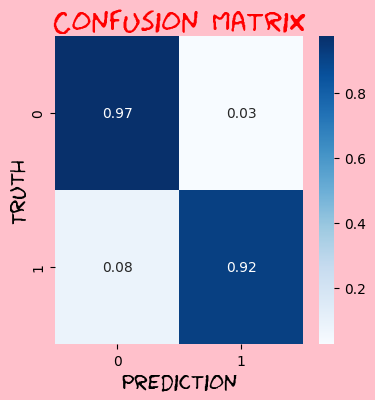

In [14]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred_labels are your true and predicted labels
cm = confusion_matrix(y_test, y_pred_labels)

# Compute percentages from counts
cm_percentages = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(4, 4), facecolor='pink', edgecolor='brown')
sn.heatmap(cm_percentages, annot=True, fmt=".2f", cmap="Blues")

plt.xlabel('Prediction', fontdict={'family': 'fantasy', 'color': 'black', 'size': 15})
plt.ylabel('Truth', fontdict={'family': 'fantasy', 'color': 'black', 'size': 15})
plt.title('Confusion Matrix', fontdict={'family': 'fantasy', 'color': 'red', 'size': 20})

plt.show()


In [15]:
from sklearn.metrics import classification_report

print('Classification Report     : \n\n\n' , classification_report(y_test,y_pred_labels))

Classification Report     : 


               precision    recall  f1-score   support

           0       0.94      0.97      0.96       345
           1       0.96      0.92      0.94       263

    accuracy                           0.95       608
   macro avg       0.95      0.95      0.95       608
weighted avg       0.95      0.95      0.95       608



In [16]:
model.save("cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
model.save("/content/drive/MyDrive/fake_vs_real/cnn.h5")